## Анализ эксперимента

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt

from scipy.stats import permutation_test
import pandas as pd
import numpy as np

alpha = 0.05

exp_testid = 34265
control_testid = 34266

seed = 177

In [44]:
def statistic_arpu(a, b):
    return np.mean(a) - np.mean(b)


def statistic_arppu(a, b):
    return np.mean(a[a != 0]) - np.mean(b[b != 0])


def revenues_by_user(df: pd.DataFrame) -> pd.DataFrame:
    return df.groupby(["userid"]).agg(
        # userid=pd.NamedAgg(column="userid", aggfunc="first"),
        val=pd.NamedAgg(column="value", aggfunc="sum"),
    ).reset_index(drop=True)


def prepare_frames(fname: str):
    df_ = pd.read_csv(fname, delimiter="\t")
    
    df_["userid"] = df_["userid"].apply(lambda x: int(x.split("_")[-1]))
    df_["value"] *= df_["action"].apply(lambda x: 1 if x == "confirmation" else 0)
    # df_.drop(["timestamp", "action"], axis=1, inplace=True)
    
    df_exp_ = df_[df_["testids"].str.contains(str(exp_testid))].drop(["testids"], axis=1)
    df_control_ = df_[df_["testids"].str.contains(str(control_testid))].drop(["testids"], axis=1)
    
    return df_, df_exp_, df_control_

In [19]:
df, df_exp, df_control = prepare_frames("exp_arppu_problem.tsv")

df.info()

df_exp.info()
df_control.info()

display(df_exp.head())
display(df_control.head())

print(set(df_exp["userid"]) & set(df_control["userid"]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 488766 entries, 0 to 488765
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userid     488766 non-null  int64  
 1   timestamp  488766 non-null  int64  
 2   action     488766 non-null  object 
 3   value      488766 non-null  float64
 4   testids    488766 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 18.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 72425 entries, 0 to 488762
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userid     72425 non-null  int64  
 1   timestamp  72425 non-null  int64  
 2   action     72425 non-null  object 
 3   value      72425 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 80368 entries, 40 to 488671
Data columns (total 4 columns):
 #   Column     Non-Null Coun

,userid,timestamp,action,value
0,10000,1659338271,mainpage,0.0
1,10000,1659424675,category,0.0
2,10000,1659424692,cart,0.0
3,10000,1659424704,checkout,0.0
4,10000,1659424709,confirmation,14400.0


,userid,timestamp,action,value
40,10001,1659559451,product,0.0
41,10001,1659732271,product,0.0
42,10001,1659732284,mainpage,0.0
43,10001,1659732285,product,0.0
44,10001,1659732311,search,0.0


set()


In [46]:
df_exp_rev = revenues_by_user(df_exp)
df_control_rev = revenues_by_user(df_control)

# df_exp_rev.info()
# df_control_rev.info()
print(len(df_exp_rev), len(df_control_rev))
print(len(df_exp_rev[df_exp_rev.val != 0]), len(df_control_rev[df_control_rev.val != 0]))
print(sum(df_exp_rev.val), sum(df_control_rev.val))

1012 976
465 612
20689561.0 24620044.0


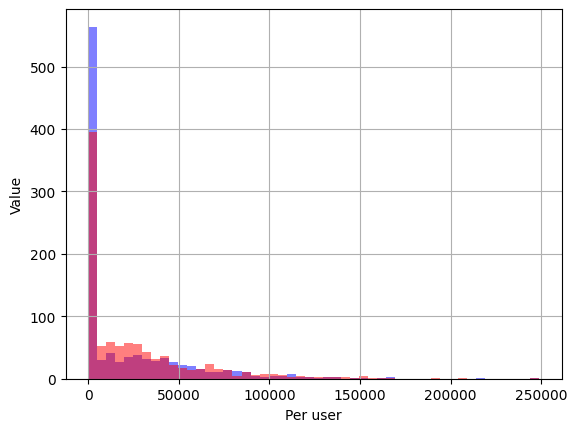

In [52]:
plt.hist(df_exp_rev.val, bins=50, color='b', alpha=0.5)
plt.hist(df_control_rev.val, bins=50, color='r', alpha=0.5)
plt.xlabel("Per user")
plt.ylabel("Value")
plt.grid()
plt.show()

ARPU

0.0014 red
True -4781.22


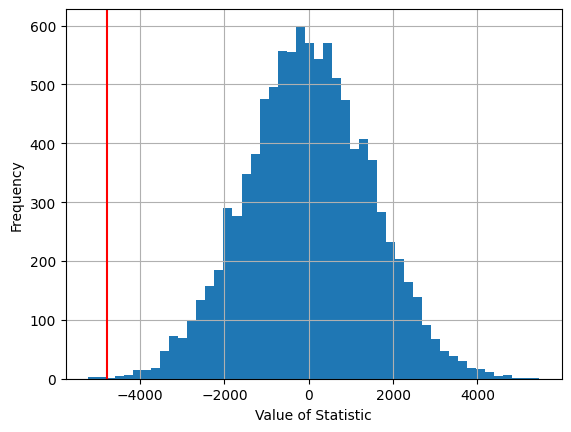

In [36]:
np.random.seed(seed)
res_1_arpu = permutation_test((df_exp_rev["val"], df_control_rev["val"]), statistic_arpu, permutation_type='independent')

c = "red" if res_1_arpu.statistic < 0 else "green"
print(round(res_1_arpu.pvalue, 5), c if res_1_arpu.pvalue < alpha else "gray")

print(res_1_arpu.pvalue < alpha, round(statistic_arpu(df_exp_rev["val"], df_control_rev["val"]), 2))

plt.hist(res_1_arpu.null_distribution, bins=50)
plt.axvline(res_1_arpu.statistic, color='r')
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.grid()
plt.show()

ARPPU

0.042 green
True 4264.85


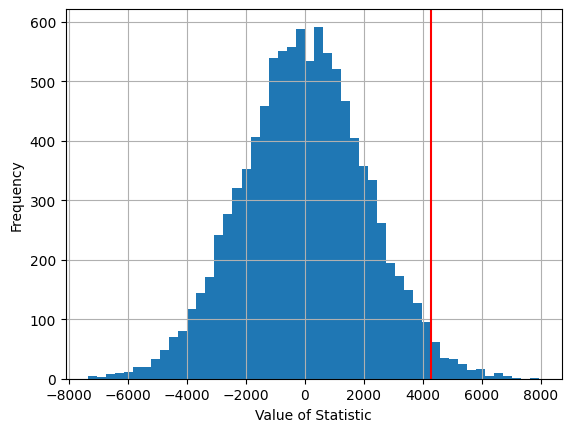

In [37]:
np.random.seed(seed)
res_2_arppu = permutation_test((df_exp_rev["val"], df_control_rev["val"]), statistic_arppu, permutation_type='independent')

c = "red" if res_2_arppu.statistic < 0 else "green"
print(round(res_2_arppu.pvalue, 5), c if res_2_arppu.pvalue < alpha else "gray")

print(res_2_arppu.pvalue < alpha, round(statistic_arppu(df_exp_rev["val"], df_control_rev["val"]), 2))

plt.hist(res_2_arppu.null_distribution, bins=50)
plt.axvline(res_2_arppu.statistic, color='r')
plt.xlabel("Value of Statistic")
plt.ylabel("Frequency")
plt.grid()
plt.show()